In [8]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score #кросс-валидация

from sklearn.model_selection import GridSearchCV #оптимизация GridSearch
from sklearn.model_selection import RandomizedSearchCV #оптимизация RandomSearch
import hyperopt #оптимизация hyperopt
from hyperopt import hp, fmin, tpe, Trials #инструменты для оптимизации hyperopt
import optuna #оптимизация optuna

In [9]:
data = pd.read_csv('data/molecules.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


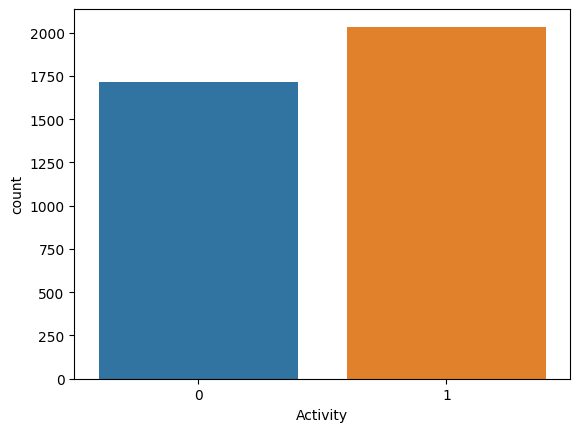

In [10]:
#проверяем данные на сбалансированность
sns.countplot(data=data, x='Activity');

Данные достаточно сбалансированы.

In [11]:
#разделяем данные на матрицу наблюдений и вектор ответов
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [12]:
#разделяем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)

# Оптимизация логистической регрессии

Создаем базовую модель и смотрим ее метрики

In [13]:
#создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=50)
#обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Grid Search**

Осуществляем оптимизацию модели с помощью класса Grid Search

In [93]:
#определим сетку гиперпараметров
param_grid = {'penalty': ['l1', 'l2'], #тип регуляризации
              'solver': ['liblinear', 'saga'], #алгоритм оптимизации
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, #уровень силы регурялизации

grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid,
    cv=5, #количество фолдов в кросс-валидации
    n_jobs = -1
)  

%time grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test) #делаем предсказание на тестовой выборке

print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 1.19 s
Wall time: 1min 42s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.7, 'penalty': 'l1', 'solver': 'liblinear'}


**Randomized Search**

Осуществляем оптимизацию модели с помощью класса Randomized Search

In [92]:

param_distributions = {'penalty': ['l1', 'l2'], #тип регуляризации
                       'solver': ['liblinear', 'saga'], #алгоритм оптимизации
                       'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, #уровень силы регурялизации
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,
        max_iter=50 #количество итераций на сходимость
        ), 
    param_distributions=param_distributions, 
    cv=5, #количество фолдов в кросс-валидации
    n_iter = 10, #количество комбинаций на расчёт
    n_jobs = -1
)  

%time random_search.fit(X_train, y_train)
y_test_pred = random_search.predict(X_test) #делаем предсказание на тестовой выборке

print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 750 ms
Wall time: 37 s
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}


**Hyperopt**

Осуществляем оптимизацию модели с помощью класса Hyperopt

In [120]:
#зададим пространство поиска гиперпараметров
space = {'penalty': hp.choice('penalty', ['l1', 'l2']), #тип регуляризации
         'solver': hp.choice('solver', ['liblinear', 'saga']), #алгоритм оптимизации
         'C': hp.quniform('C', 0.2, 0.8, 0.01)} #уровень силы регурялизации

In [121]:
#напишем функцию поиска гиперпараметров
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=42):
    #функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': (params['penalty']), 
              'solver': (params['solver']),
              'C': float(params['C'])
              }
  
    #используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, 
                                            random_state=42,
                                            max_iter=50) #количество итераций на сходимость

    #обучаем модель с помощью кросс-валидации
    model.fit(X, y)
    score = cross_val_score(model, X, y, scoring="f1", n_jobs=-1).mean()

    #метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [122]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

 10%|█         | 1/10 [00:07<01:11,  7.98s/trial, best loss: -0.7800375021534195]

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 3/10 [00:25<00:52,  7.50s/trial, best loss: -0.7854845146076939]

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 5/10 [00:40<00:34,  6.86s/trial, best loss: -0.7876014805021191]

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 6/10 [00:49<00:30,  7.71s/trial, best loss: -0.7876014805021191]

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 9/10 [01:05<00:05,  5.68s/trial, best loss: -0.7883899088765386]

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 10/10 [01:18<00:00,  7.84s/trial, best loss: -0.7883899088765386]
Наилучшие значения гиперпараметров {'C': 0.7000000000000001, 'penalty': 0, 'solver': 0}
CPU times: total: 21.7 s
Wall time: 1min 18s


In [111]:
#рассчитаем точность для тестовой выборки, задав наилучшие параметры
model = linear_model.LogisticRegression(
    random_state=42, 
    penalty='l1',
    solver='liblinear',
    C=0.7000000000000001
)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.86
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


**Optuna**

Осуществляем оптимизацию модели с помощью класса Optuna

In [123]:
#напишем функцию для поиска гиперпараметров
def optuna_lr(trial):
  #задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2']) #тип регуляризации
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga']) #алгоритм оптимизации
  C = trial.suggest_float('C', 0.2, 8, step=0.01) #уровень силы регурялизации

  #создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=42,
                                          max_iter=50)
  #обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, scoring="f1", n_jobs=-1).mean()

  return score

In [124]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2023-03-20 22:08:59,859] A new study created in memory with name: LogisticRegression
c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-03-20 22:09:21,793] Trial 0 finished with value: 0.777830514645634 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 6.3500000000000005}. Best is trial 0 with value: 0.777830514645634.
[I 2023-03-20 22:09:36,082] Trial 1 finished with value: 0.7657276668086463 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 2.79}. Best is trial 0 with value: 0.777830514645634.
c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-03-20 22:10:03,094] Trial 2 finished with value: 0.7792004586324458 and parameters: {'penalty': 

CPU times: total: 1min 30s
Wall time: 5min 42s


In [125]:
#выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.22}
f1_score на обучающем наборе: 0.79


In [126]:
#рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,
                                        random_state=42,
                                        max_iter=50)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Вывод. Grid Search работает существенно дольше остальных классов. За исключением Optuna с включенной кросс-валидацией.
Оптимизация сильно зависит от того, как мы задаем параметры.
Некорректное указание уровня силы регурялизации сильно искажает работу класса, 
так как он предлагает такие наилучшие параметры уровня силы регурялизации, которые не будут применимы на практике.
По этой причине лучшее значение метрики f1 показал класс Random Search с уровнем силы регуляризации 0.1.

# Оптимизация случайного леса

Создаем базовую модель и смотрим ее метрики

In [117]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.82


**Grid Search**

Осуществляем оптимизацию модели с помощью класса Grid Search

In [130]:
param_grid = {'n_estimators': list(range(10, 200, 10)), #количество деревьев
              'min_samples_leaf': [2, 5], #минимум сэмплов для нового листа
              'max_depth': list(np.linspace(10, 40, 5, dtype=int)) #максимальная глубина
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, #количество фолдов в кросс-валидации
    n_jobs = -1
)  

%time grid_search_forest.fit(X_train, y_train) 
y_test_pred = grid_search_forest.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 8.77 s
Wall time: 9min 57s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 17, 'min_samples_leaf': 2, 'n_estimators': 140}


**Random Search**

Осуществляем оптимизацию модели с помощью класса Random Search

In [131]:
param_distributions = {'n_estimators': list(range(10, 200, 10)), #количество деревьев
              'min_samples_leaf': [2, 5], #минимум сэмплов для нового листа
              'max_depth': list(np.linspace(10, 40, 5, dtype=int)) #максимальная глубина
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_test_pred = random_search_forest.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.72 s
Wall time: 52.5 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 2, 'max_depth': 17}


**Hyperopt**

Осуществляем оптимизацию модели с помощью класса Hyperopt

In [132]:
#зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 10, 200, 10), #количество деревьев
       'max_depth' : hp.quniform('max_depth', 10, 40, 5), #максимальная глубина
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 5, 1) #минимум сэмплов для нового листа
      }

In [133]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    #функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    #используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=42)

    #обучаем модель с помощью кросс-валидации
    model.fit(X, y)
    score = cross_val_score(model, X, y, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [134]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() #используется для логирования результатов

best=fmin(hyperopt_rf, #наша функция 
          space=space, #пространство гиперпараметров
          algo=tpe.suggest, #алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, #максимальное количество итераций
          trials=trials, #логирование результатов
          rstate=np.random.default_rng(random_state) #фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:38<00:00,  4.95s/trial, best loss: -0.8196966149842488]
Наилучшие значения гиперпараметров {'max_depth': 25.0, 'min_samples_leaf': 2.0, 'n_estimators': 150.0}
CPU times: total: 34.3 s
Wall time: 1min 38s


In [135]:
#рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.82


**Optuna**

Осуществляем оптимизацию модели с помощью класса Optuna

In [136]:
def optuna_rf(trial):
  #задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 10, 200, 10) #количество деревьев
  max_depth = trial.suggest_int('max_depth', 10, 40, 5) #максимальная глубина
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1) #минимум сэмплов для нового листа

  #создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  #обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, scoring="f1", n_jobs=-1).mean()

  return score

In [137]:
%%time
#cоздаем объект исследования
#можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
#ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-03-20 22:51:26,278] A new study created in memory with name: RandomForestClassifier
[I 2023-03-20 22:51:40,138] Trial 0 finished with value: 0.8087178270867721 and parameters: {'n_estimators': 190, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8087178270867721.
[I 2023-03-20 22:51:48,043] Trial 1 finished with value: 0.8107832005550011 and parameters: {'n_estimators': 120, 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8107832005550011.
[I 2023-03-20 22:51:52,730] Trial 2 finished with value: 0.8075158599118974 and parameters: {'n_estimators': 80, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8107832005550011.
[I 2023-03-20 22:51:56,236] Trial 3 finished with value: 0.8077620071509506 and parameters: {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8107832005550011.
[I 2023-03-20 22:52:06,542] Trial 4 finished with value: 0.8127590534741186 and parameters: {'n_es

CPU times: total: 48.2 s
Wall time: 2min 39s


In [138]:
#выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 2}


In [140]:
#рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.82


Выводы. Все классы показали себя одинаково с точки зрения итоговой полученной метрики f1.
При этом класс Grid Search работал намного дольше остальных классов.
Интересно, что все классы подобрали разные оптимальные параметры для модели, обеспечитив
при этом одинаковый показатель метрики.